# トピックモデル(Latent Dirichlet Allocation, LDA)の実装
---
pythonのgensim(トピックモデルのライブラリ）を使って簡単な実装をしてみる．  
目的は**顧客のクラスタを発見し，クラスタごとの購入傾向を観察する**こと．  
今回は，各顧客が購入した商品の**item_category_2の情報だけ**使用して簡単な分析をしてみた．  

### 目次  
- 前処理  
 - テーブルの準備  
 - BOW表現に変換
 - 辞書の作成
 - コーパスの作成　
- 実行部分
 - LDAの実行
 - トピック（クラスタ）の数を推定
 - トピックごとの距離
 - トピックごとの傾向

## 前処理
---
実行の前に必要な前処理をしておく．

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import gensim
from gensim import corpora
import time

order = pd.read_csv("/Users/TakayukiYagi/Developer/M1/competition/data/order.csv")
detail = pd.read_csv("/Users/TakayukiYagi/Developer/M1/competition/data/order_detail.csv")
item = pd.read_csv("/Users/TakayukiYagi/Developer/M1/competition/data/item.csv")

df = pd.merge(pd.merge(order, detail, on='order_id', how='left'), item, on='item_id', how='left')[['customer_id', 'item_category_2']].dropna()

print(u'unique user数 : ', len(set(df.customer_id)), u'人')
print(u'カテゴリの種類 : ', len(set(df.item_category_2)), u'種類')

unique user数 :  101491 人
カテゴリの種類 :  226 種類


In [3]:
unique_customer_id = set(df.customer_id)
dict_customer_id = dict(zip(list(unique_customer_id), [i for i in range(len(unique_customer_id))]))

df.customer_id= df.customer_id.apply(lambda x: dict_customer_id[x])

bows = [[] for i in range(len(unique_customer_id))]
for (c, i) in df.as_matrix():
    bows[c].append(str(i))
    
bows = list(filter(lambda x: len(x)>10, bows))

dictionary = corpora.Dictionary(bows)

corpus = [dictionary.doc2bow(bow) for bow in bows]

## LDAの実行
---

In [4]:
p = int(len(corpus)*0.6)
corpus_train = corpus[0:p]
corpus_test = corpus[p:]

topic_number : 1
Elapsed time : 7.505068063735962
Perplexity : 38.5218709832

topic_number : 3
Elapsed time : 45.15498995780945
Perplexity : 29.90129181

topic_number : 5
Elapsed time : 37.809755086898804
Perplexity : 24.5737871878

topic_number : 7
Elapsed time : 35.914690017700195
Perplexity : 21.9289130219

topic_number : 10
Elapsed time : 37.025914907455444
Perplexity : 19.0122957546

topic_number : 15
Elapsed time : 38.9236421585083
Perplexity : 16.7453139199

topic_number : 20
Elapsed time : 37.1246919631958
Perplexity : 14.7014531195

topic_number : 30
Elapsed time : 48.86749291419983
Perplexity : 13.334344987

topic_number : 40
Elapsed time : 45.16479301452637
Perplexity : 12.4856956116

topic_number : 50
Elapsed time : 46.56212496757507
Perplexity : 11.7824471686



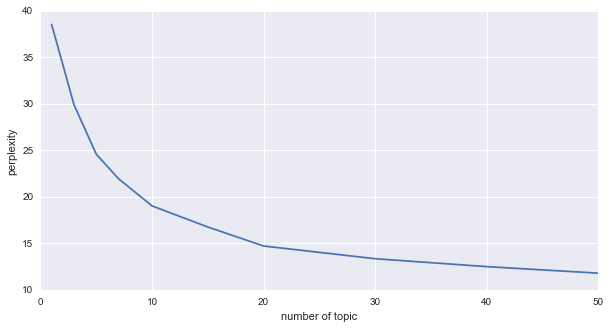

In [5]:
num_of_topics = [1, 3, 5, 7, 10, 15, 20, 30, 40, 50]
perplex_list = []

def calc_perplexity(m, c):
    return np.exp(-m.log_perplexity(c))

for k in num_of_topics:
    print("topic_number : %d" %k)
    start_time = time.time()
    
    # モデル実行
    model = gensim.models.ldamodel.LdaModel(corpus=corpus_train, id2word=dictionary, num_topics=k)
    
    # 経過時間表示
    print("Elapsed time : %s" %(time.time() - start_time))
    
    # Perplexity(評価基準)の表示
    perplexity =  calc_perplexity(model, corpus_test)
    print("Perplexity : %s" %perplexity)
    perplex_list.append(perplexity)
    
    print("")

plt.figure(figsize=(10, 5))
plt.plot(num_of_topics, perplex_list)
plt.ylabel("perplexity")
plt.xlabel("number of topic")

topic数を10に設定して再計算する

In [ ]:
model = gensim.models.ldamodel.LdaModel(corpus=corpus_train, id2word=dictionary, num_topics=10)

In [ ]:
def calc_topic_distances(model, topic):
    
    def kldiv(p, q):
        distance = np.sum(p * np.log(p / q))
        return distance
    
    t = model.state.get_lambda()
    for i in range(len(t)):
        t[i] = t[i] / sum(t[i])

    base = t[topic]
    distances = [(i_p[0], kldiv(base, i_p[1])) for i_p in enumerate(t) if i_p[0] != topic]
    return distances

def plot_distance_matrix(model):
    
    mt = []
    for i in range(model.num_topics):
        d = calc_topic_distances(model, i)
        d.insert(i, (i, 0)) 
        d = [_d[1] for _d in d]
        mt.append(d)

    mt = np.array(mt)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(mt, interpolation="nearest", cmap=plt.cm.ocean)
    plt.yticks(range(mt.shape[0]))
    plt.xticks(range(mt.shape[1]))
    plt.colorbar()
    plt.show()

plot_distance_matrix(model)

やっぱり全体的に集団が近い。。。こんなもんなのかな。。細かく分けすぎなのかな。。

In [12]:
for k in range(model.num_topics):
    print("-----  topic %d  -----" %k)
    print("")
    res = model.show_topic(k, topn=5)
    for (text, p) in res:
        print(str(round(p*100,1)).rjust(4),"%   ", text)
    print("")

-----  topic 0  -----

35.7 %    パーカー
13.1 %    ドレスシューズ
10.7 %    ストール/スヌード
 4.5 %    ダッフルコート
 4.3 %    ヘアゴム

-----  topic 1  -----

56.4 %    パンプス
17.6 %    タンクトップ
 3.1 %    スカート
 2.9 %    ワンピース
 1.7 %    ニット/セーター

-----  topic 2  -----

87.4 %    スニーカー
 1.9 %    Tシャツ/カットソー
 0.7 %    バックパック/リュック
 0.5 %    ニットキャップ/ビーニー
 0.5 %    トートバッグ

-----  topic 3  -----

54.0 %    カーディガン
 7.3 %    ダウンジャケット/コート
 3.0 %    ハンカチ/ハンドタオル
 2.3 %    インテリアアクセサリー
 2.2 %    キッチンツール

-----  topic 4  -----

33.2 %    チノパンツ
15.0 %    ブレスレット
10.6 %    その他シューズ
 6.8 %    福袋/福箱
 5.8 %    Tシャツ/カットソー

-----  topic 5  -----

25.1 %    ブーツ
 6.5 %    チェスターコート
 6.1 %    トートバッグ
 4.9 %    その他アウター
 4.5 %    ショルダーバッグ

-----  topic 6  -----

67.0 %    サンダル
 3.4 %    スカート
 1.6 %    パンツ
 1.2 %    ルームシューズ/スリッパ
 1.2 %    クッション/クッションカバー

-----  topic 7  -----

63.3 %    ニット/セーター
 9.7 %    スカート
 6.0 %    ポロシャツ
 4.9 %    Tシャツ/カットソー
 1.6 %    シャツ/ブラウス

-----  topic 8  -----

27.6 %    ワンピース
26.4 %    ブラ&ショーツ
 5.1 %    ニットキャップ/ビーニー
 4

でもなんとなくわかれてるっぽい。  
LDA優秀..!!  
集団ごとにちゃんと分析したらもっと面白いのかも。